### Der Welch-t-Test (zwei unabhängige Gruppen) - mit SPSS-Ausgabe

Wir simulieren systolische Blutdruckdaten (mmHg) für zwei unabhängige Gruppen
(Therapie vs. Kontrolle) und testen die Nullhypothese
$$
H_0:\ \mu_{\text{Therapie}} - \mu_{\text{Kontrolle}} = 0
$$
mit dem **Welch-t-Test**, der keine Varianzgleichheit voraussetzt.
Die Teststatistik
$$
t = \frac{\bar{x}_T - \bar{x}_K}{\sqrt{\frac{s_T^2}{n_T} + \frac{s_K^2}{n_K}}}
$$
misst den beobachteten Mittelwertunterschied relativ zu seiner zufälligen Streuung.
Die (nicht-ganzzahligen) Freiheitsgrade werden über die Welch–Satterthwaite-Approximation
bestimmt; Entscheidungsstruktur und Interpretation bleiben identisch zum klassischen t-Test.


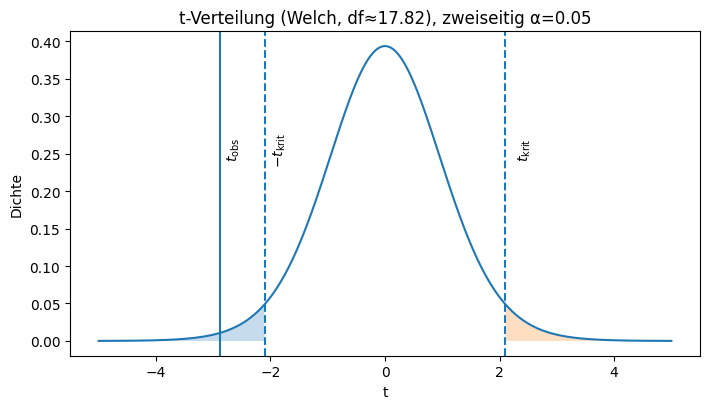

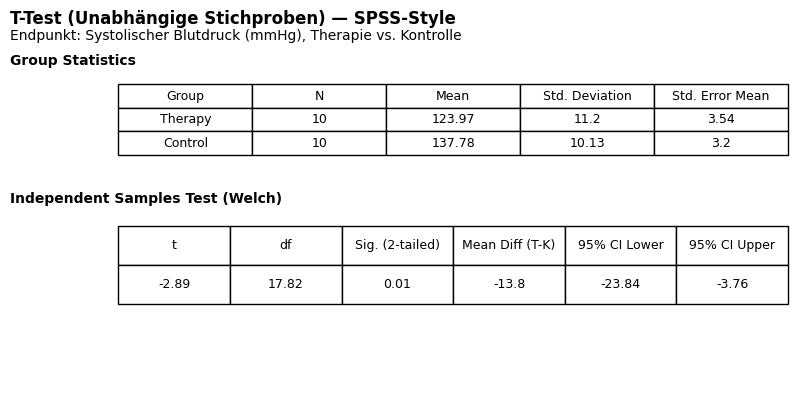

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math

# ----------------------------
# 1) Beispiel: Blutdruckdaten
# ----------------------------
rng = np.random.default_rng(42)  #seed (Startbeginn: Zufallsgenerator, None: zufälliger Beginn) 

n = 10  # Anzahl der Personen in jeder Gruppe
therapy = rng.normal(128, 12, size=n)   # Therapiegruppe
control = rng.normal(134, 14, size=n)   # Kontrollgruppe

# Welch t-test
t_stat, p_val = stats.ttest_ind(therapy, control, equal_var=False)

n1, n2 = len(therapy), len(control)    
m1, m2 = therapy.mean(), control.mean()             # Mittelwert
s1, s2 = therapy.std(ddof=1), control.std(ddof=1)   # Standardabweichung
v1, v2 = s1**2, s2**2                               # Varianz

# Welch df
df = (v1/n1 + v2/n2)**2 / ((v1/n1)**2/(n1-1) + (v2/n2)**2/(n2-1))

diff = m1 - m2
se = math.sqrt(v1/n1 + v2/n2)              # Standardfehler
tcrit = stats.t.ppf(0.975, df)             # Quantil (t_{tcrit})
ci = (diff - tcrit*se, diff + tcrit*se)    # Konfidenzintervall

# ----------------------------
# 2) Pseudo-SPSS Tabellen
# ----------------------------
desc = pd.DataFrame({
    "Group": ["Therapy", "Control"],
    "N": [n1, n2],
    "Mean": [m1, m2],
    "Std. Deviation": [s1, s2],
    "Std. Error Mean": [s1/np.sqrt(n1), s2/np.sqrt(n2)]
})

test = pd.DataFrame({
    "t": [t_stat],
    "df": [df],
    "Sig. (2-tailed)": [p_val],
    "Mean Difference (T-K)": [diff],
    "Std. Error Diff": [se],
    "95% CI Lower": [ci[0]],
    "95% CI Upper": [ci[1]],
})

# Runde Werte (SPSS-Look)
desc_r = desc.copy()
for col in ["Mean","Std. Deviation","Std. Error Mean"]:
    desc_r[col] = desc_r[col].map(lambda x: round(float(x),2))

test_r = test.copy()
test_r["t"] = test_r["t"].map(lambda x: round(float(x),3))
test_r["df"] = test_r["df"].map(lambda x: round(float(x),2))
test_r["Sig. (2-tailed)"] = test_r["Sig. (2-tailed)"].map(lambda x: round(float(x),3))
for col in ["Mean Difference (T-K)","Std. Error Diff","95% CI Lower","95% CI Upper"]:
    test_r[col] = test_r[col].map(lambda x: round(float(x),2))

# ----------------------------
# 3) t-Verteilung mit Ablehnungsbereich (PDF/PNG)
# ----------------------------
alpha = 0.05
tcrit = stats.t.ppf(1 - alpha/2, df)

x = np.linspace(-5, 5, 4000)
y = stats.t.pdf(x, df)

plt.figure(figsize=(7.2, 4.2))
plt.plot(x, y)

mask_left = x <= -tcrit
mask_right = x >= tcrit
plt.fill_between(x[mask_left], 0, y[mask_left], alpha=0.25)
plt.fill_between(x[mask_right], 0, y[mask_right], alpha=0.25)

plt.axvline(-tcrit, linestyle='--')
plt.axvline(tcrit, linestyle='--')
plt.axvline(t_stat, linestyle='-')

plt.title(f"t-Verteilung (Welch, df≈{df:.2f}), zweiseitig α={alpha}")
plt.xlabel("t")
plt.ylabel("Dichte")

plt.text(tcrit+0.2, max(y)*0.65, r"$t_{\mathrm{krit}}$", rotation=90, va="center")
plt.text(-tcrit+0.4, max(y)*0.65, r"$-t_{\mathrm{krit}}$", rotation=90, va="center", ha="right")
plt.text(t_stat+0.1, max(y)*0.65, r"$t_{\mathrm{obs}}$", rotation=90, va="center")

plt.tight_layout()
plt.savefig("bp_t_ablehnungsbereich.pdf", bbox_inches="tight")
plt.savefig("bp_t_ablehnungsbereich.png", dpi=200, bbox_inches="tight")
plt.show()

# ----------------------------
# 4) Pseudo-SPSS "Screenshot" (PDF/PNG)
# ----------------------------
fig, ax = plt.subplots(figsize=(9, 4.6))
ax.axis("off")

fig.text(0.02, 0.95, "T-Test (Unabhängige Stichproben) — SPSS-Style", fontsize=12, weight="bold")
fig.text(0.02, 0.915, "Endpunkt: Systolischer Blutdruck (mmHg), Therapie vs. Kontrolle", fontsize=10)

fig.text(0.02, 0.86, "Group Statistics", fontsize=10, weight="bold")
tbl1 = ax.table(
    cellText=desc_r[["Group","N","Mean","Std. Deviation","Std. Error Mean"]].values,
    colLabels=["Group","N","Mean","Std. Deviation","Std. Error Mean"],
    cellLoc="center",
    bbox=[0.02, 0.72, 0.96, 0.2]
)
tbl1.auto_set_font_size(False)
tbl1.set_fontsize(9)

fig.text(0.02, 0.56, "Independent Samples Test (Welch)", fontsize=10, weight="bold")
tbl2 = ax.table(
    cellText=test_r[["t","df","Sig. (2-tailed)","Mean Difference (T-K)","95% CI Lower","95% CI Upper"]].values,
    colLabels=["t","df","Sig. (2-tailed)","Mean Diff (T-K)","95% CI Lower","95% CI Upper"],
    cellLoc="center",
    bbox=[0.02, 0.30, 0.96, 0.22]
)
tbl2.auto_set_font_size(False)
tbl2.set_fontsize(9)

#fig.text(
 #   0.02, 0.08,
 #   "Mentale Rückübersetzung: Parameter = Mittelwertdifferenz; Unsicherheit = 95%-KI; "
 #   "Entscheidung (zweiseitig) über Nullwert (0) im KI.",
 #   fontsize=9
#)

plt.savefig("bp_spss_ttest.png", dpi=200, bbox_inches="tight")
plt.savefig("bp_spss_ttest.pdf", bbox_inches="tight")
plt.show()
